# Sprawozdanie z Projektu: Środowisko Gymnasium "ArcticDashEnv" (Q-learning z Curriculum Learning)

**Autorzy:** Kacper Machnik, Michał Krzempek <br>
**Data:** 28.05.2025 <br>
**Przedmiot:** Inteligencja obliczeniowa w analizie danych cyfrowych <br>

---

## 0. Wstęp i Konfiguracja Środowiska Colab/Jupyter

### 0.1. Cel Projektu
Celem niniejszego projektu było stworzenie własnego, niestandardowego środowiska w ramach biblioteki Gymnasium, nazwanego `ArcticDashEnv`. Następnie, zaimplementowano i przetestowano agenta opartego na sztucznej inteligencji, wykorzystującego algorytm Q-learning oraz strategię Curriculum Learning, w celu rozwiązania problemu postawionego w tym środowisku. Projekt obejmował również implementację trybu graficznego dla środowiska.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time
import logging
from IPython.display import Image as IPImage, display
from gymnasium_env.envs import ArcticDashEnv

In [2]:
logger = logging.getLogger('ArcticDashEnv_LOG')
logger.setLevel(logging.INFO)
logger.propagate = False
if not any(isinstance(h, logging.StreamHandler) for h in logger.handlers):
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)

## 1. Opis Zaimplementowanego Środowiska Gymnasium (`ArcticDashEnv`)
### 1.1. Wprowadzenie i Koncepcja Gry
W środowisku `ArcticDashEnv` agent porusza się po siatce reprezentującej zamarznięte jezioro. Celem jest zebranie skarbu ('G') i bezpieczny powrót na pole startowe ('S'). Agent dysponuje ograniczoną liczbą skoków, które pozwalają mu pokonywać większe odległości lub potencjalnie omijać niebezpieczne pola.

### 1.2. Przestrzeń Stanów (`Observation Space`)
* **Definicja:** Stan agenta jest w pełni obserwowalny i składa się z trzech komponentów:
    1.  **Pozycja przestrzenna agenta (s_spatial):** Indeks pola na siatce (od 0 do `nrow * ncol - 1`).
    2.  **Liczba pozostałych skoków (jumps_left):** Liczba całkowita od 0 do `max_jumps`.
    3.  **Posiadanie skarbu (has_treasure):** Wartość logiczna (True/False).
* **Typ:** Dyskretna.
* **Rozmiar:** Całkowita liczba unikalnych stanów jest obliczana jako: <br> `num_spatial_states * (max_jumps + 1) * 2`.
    * Dla naszej mapy o wymiarach 40 x 11 mamy `440 pól`. Dla np. `max_jumps = 10` mamy `440 * (10 + 1) * 2 = 400 * 9 * 2 = 9680` stanów.

### 1.3. Przestrzeń Akcji (`Action Space`)
* **Definicja:** Agent może wykonać jedną z 8 dyskretnych akcji (zdefiniowanych jako stałe `MOVE_LEFT`, `JUMP_UP` itd.):
    * Ruch w lewo, w dół, w prawo, w górę (o jedno pole).
    * Skok w lewo, w dół, w prawo, w górę (o dwa pola).

### 1.4. Dynamika Środowiska i Zasady Gry
* **Ruch i Skoki:**
    * Zwykły ruch przesuwa agenta o jedno pole w wybranym kierunku.
    * Skok przesuwa agenta o dwa pola i zużywa jeden z dostępnych skoków. Próba skoku bez dostępnych skoków kończy epizod z wysoką karą.
    * Ruch lub skok poza granice mapy również kończy epizod z karą.
* **Interakcja z Polami:**
    * **'S' (Start):** Pole początkowe. Powrót tutaj ze skarbem oznacza wygraną.
    * **'G' (Goal/Treasure):** Pole, na którym znajduje się skarb. Wejście na to pole po raz pierwszy (bez skarbu) skutkuje podniesieniem skarbu i pozytywną nagrodą.
    * **'F' (Frozen):** Bezpieczne pole lodowe - po wejściu zamienia się w 'W' (Weak Ice).
    * **'W' (Weak Ice):** Kruchy lód. Po pierwszym wejściu (ruch lub skok) zamienia się w 'V' (Very Weak Ice) lub 'H' (Hole), jeśli był to skok na 'W'.
    * **'V' (Very Weak Ice):** Bardzo kruchy lód. Po wejściu (ruch lub skok) zamienia się w 'H' (Hole).
    * **'H' (Hole):** Dziura. Wejście na to pole kończy epizod z wysoką karą.
* **Warunki Zakończenia Epizodu (`terminated`):**
    * Agent wpada do dziury ('H').
    * Agent wykonuje ruch lub skok poza granice mapy.
    * Agent próbuje wykonać skok, nie mając już dostępnych skoków.
    * Agent dociera na pole startowe ('S') posiadając skarb (stan zwycięstwa).
* **Warunki Przerwania Epizodu (`truncated`):**
    * Osiągnięcie maksymalnej liczby kroków w epizodzie (narzucone przez `TimeLimit` wrapper Gymnasium).

### 1.5. System Nagród (`Reward System`)
Struktura nagród została zaprojektowana, aby zachęcić agenta do osiągnięcia celu:
* **`goal_reward` (+100,000):** Za dotarcie na pole 'S' z posiadanym skarbem.
* **`pickup_reward` (+1,000):** Za podniesienie skarbu z pola 'G'.
* **`hole_penalty` (-200):** Za wpadnięcie do dziury 'H'.
* **`move_cost` (-1.0):** Niewielki koszt za każdy standardowy ruch.
* **`jump_cost` (-7.5):** Większy koszt za każdy wykonany skok.
* **Kara za nieprawidłowy ruch/skok (np. poza mapę, brak skoków):** Domyślnie -400.
Celem jest znalezienie optymalnej ścieżki, która maksymalizuje sumę tych nagród.

### 1.6. Tryb Graficzny (Pygame)
Środowisko posiada zaimplementowany tryb graficzny z wykorzystaniem biblioteki Pygame.
* **Wizualizacja:** Mapa jest renderowana jako siatka kafelków, gdzie każdy typ pola ma odrębną grafikę. Skarb jest widoczny na polu 'G' (dopóki nie zostanie podniesiony) oraz jako ikona przy agencie, jeśli go posiada.
* **Śledzenie Ścieżki:** W trybie interaktywnym (`interactive_mode=True`), ścieżka przebyta przez agenta w danym epizodzie jest rysowana czerwoną linią.
* **Panel Informacyjny:** Wyświetla kluczowe informacje, takie jak:
    * Liczba pozostałych skoków / maksymalna liczba skoków.
    * Status posiadania skarbu.
    * Aktualny poziom zoomu i wskazówki dotyczące jego zmiany (+/-).
    * Status kamery (czy podąża za agentem) i klawisz do przełączania (C).
    * Aktualne FPS i klawisze do zmiany (PgUp/PgDn).
    * Informacja o trybie pełnoekranowym (F11).
    * W trybie interaktywnym, informacja o możliwości resetu klawiszem 'R'.
    * Ostatnia wykonana akcja.
* **Interaktywność:** Użytkownik może kontrolować zoom, przełączać tryb kamery, FPS oraz tryb pełnoekranowy. W specjalnym trybie interaktywnym (gdy `PERFORM_TRAINING_OVERALL = False`), po zakończeniu epizodu (wygrana, przegrana, błąd), gra zatrzymuje się, a użytkownik może zresetować środowisko klawiszem 'R', aby spróbować ponownie.

* ![Interfejs graficzny gry 'ArcticDash'](./demonstration/UI.png)

---


## 2. Definicja Problemu Rozwiązywanego przez Agenta

Problem stawiany przed agentem AI polega na nauczeniu się optymalnej strategii (sekwencji akcji) w środowisku `ArcticDashEnv`. Celem jest maksymalizacja oczekiwanej sumarycznej nagrody w długim okresie. Konkretnie, agent musi:
1.  Rozpocząć na polu startowym 'S'.
2.  Dotrzeć do pola 'G', aby podnieść skarb.
3.  Po podniesieniu skarbu, wrócić na pole startowe 'S'.
4.  Podczas realizacji tych celów, agent powinien:
    * Efektywnie zarządzać ograniczoną liczbą dostępnych skoków.
    * Unikać wpadania do dziur ('H').
    * Minimalizować negatywne nagrody związane z kosztami ruchu i skoków.
    * Unikać nieprawidłowych akcji (np. ruch poza mapę).

Rozwiązanie problemu oznacza znalezienie takiej polityki $\pi(s) \rightarrow a$, która dla każdego stanu $s$ wskazuje optymalną akcję $a$ do wykonania.

---

## 3. Zastosowany Algorytm Uczący: Q-learning z Curriculum Learning
Do rozwiązania postawionego problemu wykorzystano algorytm Q-learning, wspomagany strategią Curriculum Learning.

### 3.1. Q-learning
Q-learning jest algorytmem uczenia ze wzmocnieniem typu model-free, off-policy, opartym na wartościach. Jego celem jest nauka funkcji wartości akcji Q(s, a), która estymuje oczekiwaną sumaryczną nagrodę (dyskontowaną) za wykonanie akcji $a$ w stanie $s$ i następnie postępowanie zgodnie z optymalną polityką.

* **Funkcja Q(s,a):** Reprezentuje jakość (oczekiwaną przyszłą nagrodę) wykonania akcji $a$ w stanie $s$.
* **Równanie Bellmana dla Q-learning:** Optymalna funkcja wartości akcji $Q^*(s,a)$ spełnia równanie Bellmana:
  $$
  Q^*(s,a) = E\left[R_{t+1} + \gamma \max_{a'} Q^*(S_{t+1}, a') \mid S_t=s, A_t=a\right]
  $$

  gdzie $R_{t+1}$ to nagroda otrzymana po wykonaniu akcji $A_t$ w stanie $S_t$ i przejściu do stanu $S_{t+1}$, a $\gamma$ to współczynnik dyskontowania.


* **Reguła Aktualizacji:** Wartości Q są iteracyjnie aktualizowane w trakcie interakcji agenta ze środowiskiem za pomocą reguły:
  $$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a') - Q(S_t, A_t)]$$
  gdzie:
  * $S_t, A_t$ – aktualny stan i akcja.
  * $R_{t+1}$ – otrzymana nagroda.
  * $S_{t+1}$ – następny stan.
  * $\alpha$ (learning rate) – współczynnik uczenia, kontrolujący, jak duży wpływ na aktualizację ma nowa informacja.
  * $\gamma$ (discount factor) – współczynnik dyskontowania, określający wagę przyszłych nagród.
  * $\max_{a'} Q(S_{t+1}, a')$ – estymacja optymalnej przyszłej wartości, zaczynając od stanu $S_{t+1}$.

### 3.2. Reprezentacja Stanu dla Tablicy Q
Ponieważ stan w środowisku `ArcticDashEnv` jest złożony (pozycja przestrzenna, liczba pozostałych skoków, posiadanie skarbu), konieczne było zmapowanie go na pojedynczy, unikalny indeks dla tablicy Q. Wykorzystano do tego funkcję `get_full_state_index`. Funkcja ta przypisuje każdemu możliwemu stanowi złożonemu liczbę całkowitą, która służy jako indeks wiersza w tablicy Q. Tablica Q ma wymiary `[całkowita_liczba_stanów_złożonych, liczba_akcji]`.

In [3]:
def get_full_state_index(spatial_s, jumps_left, has_treasure, max_jumps_val, num_spatial_states):
    num_jump_states = max_jumps_val + 1
    jumps_left_clipped = np.clip(jumps_left, 0, max_jumps_val)
    treasure_int = 1 if has_treasure else 0
    index = treasure_int * (num_spatial_states * num_jump_states) + \
            jumps_left_clipped * num_spatial_states + \
            spatial_s
    return int(index)

### 3.3. Eksploracja vs. Eksploatacja: Strategia Epsilon-Greedy
Aby zapewnić odpowiedni balans między eksploracją (odkrywaniem nowych, potencjalnie lepszych akcji) a eksploatacją (wykorzystywaniem już nabytej wiedzy do wyboru najlepszych znanych akcji), zastosowano strategię $\epsilon$-greedy.
* Z prawdopodobieństwem $\epsilon$, agent wybiera losową akcję spośród wszystkich dostępnych.
* Z prawdopodobieństwem $1-\epsilon$, agent wybiera akcję, która ma najwyższą aktualnie oszacowaną wartość Q dla bieżącego stanu (zachłannie).

Wartość $\epsilon$ była dynamicznie zmniejszana w trakcie treningu. W naszym projekcie zastosowano wieloetapowy harmonogram zanikania $\epsilon$ (oznaczony jako S1-S4 w kodzie), gdzie $\epsilon$ zaczynało od wysokiej wartości (1.0, pełna eksploracja) i stopniowo malało w kolejnych fazach treningu do niskiej wartości końcowej (0.05). Taki schemat pozwala na intensywną eksplorację na początku uczenia, a następnie coraz częstsze wykorzystywanie nauczonej polityki w miarę postępów treningu. Konkretne wartości progowe i współczynniki zanikania dla poszczególnych faz (S1, S2, S3, S4) zostały zdefiniowane w kodzie i miały na celu systematyczne ograniczanie losowości decyzji agenta.

### 3.4. Curriculum Learning (Adaptacyjne Strategie w Zależności od Zasobów)

W projekcie zastosowano podejście inspirowane strategią Curriculum Learning, jednak z głównym naciskiem na analizę adaptacji strategii agenta. Zamiast tradycyjnego stopniowego zwiększania ogólnej trudności problemu, celem było zaobserwowanie, jak agent modyfikuje swoje ścieżki i proces decyzyjny w odpowiedzi na zmianę kluczowego zasobu – dostępnej liczby maksymalnych skoków (`max_jumps`).

Proces przebiegał następująco:
1.  **Seria Etapów z Różną Liczbą Skoków:** Agent był trenowany w kilku wariantach środowiska, gdzie każdy wariant różnił się zdefiniowaną maksymalną liczbą skoków dostępnych dla agenta (np. trenowano osobne modele dla `max_jumps = 10`, następnie od `max_jumps = 9`, do `max_jumps = 2`).
2.  **Inicjalizacja i Transfer Wiedzy:** Choć głównym celem była obserwacja różnych strategii, w przypadku treningu kolejnych modeli (np. od większej do mniejszej liczby skoków) można było zastosować transfer wiedzy. Nauczona tablica Q z etapu z większą liczbą skoków mogła być użyta do częściowej inicjalizacji tablicy Q dla etapu z mniejszą liczbą skoków. Wartości Q dla stanów wspólnych (ta sama pozycja, status skarbu, liczba pozostałych skoków mieszcząca się w nowym limicie) były przenoszone. Miało to na celu potencjalne przyspieszenie konwergencji na etapach z mniejszą liczbą skoków, ale przede wszystkim pozwalało zobaczyć, jak agent adaptuje "ogólniejszą" wiedzę do bardziej restrykcyjnych warunków.
3.  **Analiza Strategii:** Kluczowym elementem było porównanie wyuczonych (lub stosowanych) polityk i typowych ścieżek agenta dla różnych ustawień `max_jumps`. Obserwowano, czy agent:
    * Przy dużej liczbie skoków wybiera krótsze, ale potencjalnie bardziej ryzykowne trasy, częściej używając skoków.
    * Przy małej liczbie skoków staje się bardziej zachowawczy, oszczędza skoki na kluczowe momenty, wybiera dłuższe, ale bezpieczniejsze ścieżki wymagające głównie standardowych ruchów.
    * Jak zmienia się jego podejście do omijania pól z kruchym lodem lub pokonywania większych odległości.

Główne cele takiego podejścia to:
* **Zrozumienie adaptacyjności agenta:** Zobaczenie, jak zmiana ograniczeń zasobów wpływa na optymalną strategię.
* **Wizualizacja różnych rozwiązań problemu:** Pokazanie, że ten sam cel (zdobycie skarbu i powrót) może być osiągany na różne sposoby w zależności od dostępnych narzędzi (skoków).
* **Ocena "inteligencji" agenta:** Czy potrafi on sensownie dostosować swoje zachowanie, czy też jego strategie są sztywne i nieefektywne przy zmianie warunków?
* **Potencjalne przyspieszenie nauki (aspekt tradycyjnego Curriculum Learning):** Jeśli kolejne etapy były trenowane z transferem wiedzy, można było zaobserwować wpływ na szybkość uczenia.

### 3.5. Główne Hiperparametry Algorytmu
W procesie treningu agenta Q-learning kluczowe były następujące hiperparametry:
* **Współczynnik uczenia ($\alpha$, `learning_rate`):** W projekcie zastosowano dynamiczny współczynnik uczenia. Rozpoczynał się od wartości `initial_static_lr = 0.05` i liniowo malał do `min_final_lr = 0.001` począwszy od epizodu `lr_decay_start_episode` (połowy całkowitej liczby epizodów).
* **Współczynnik dyskontowania ($\gamma$, `discount_factor`):** Ustawiony na `discount_factor = 0.99`. Wysoka wartość oznacza, że agent bierze pod uwagę długoterminowe konsekwencje swoich działań i ceni przyszłe nagrody.
* **Harmonogram Epsilon ($\epsilon$):** Zastosowano wielostopniowy, wykładniczy zanik wartości epsilon, aby kontrolować balans eksploracja-eksploatacja:
    * Faza 1 (S1): od 1.0 (`s1_start_epsilon`) do 0.9 (`s1_end_epsilon`) przez pierwsze 25% (`s1_duration_episodes`) epizodów.
    * Faza 2 (S2): od 0.9 (`s2_start_epsilon`) do 0.6 (`s2_end_epsilon`) przez kolejne 25% (`s2_duration_episodes`) epizodów.
    * Faza 3 (S3): od 0.6 (`s3_start_epsilon`) do 0.35 (`s3_end_epsilon`) przez kolejne 25% (`s3_duration_episodes`) epizodów.
    * Faza 4 (S4): od 0.35 (`s4_start_epsilon`) do 0.05 (`s4_end_epsilon`) przez kolejne 12.5% (`s4_duration_episodes`) epizodów.
    * Wartość końcowa: Utrzymanie `final_epsilon_after_decay = 0.05` dla pozostałych epizodów.
* **Liczba epizodów na etap curriculum (`EPISODES_PER_STAGE`):** `30,000,000` dla etapów od 10-5 skoków, `50,000,000` dla 4-3 skoków oraz `100,000,000` dla 2 skoków.
* **Maksymalna liczba kroków na epizod (`CUSTOM_MAX_STEPS_PER_EPISODE`):** `600`, aby zapobiec nieskończonym epizodom i przyspieszyć naukę w przypadku polityk prowadzących do cykli.


---

## 4. Implementacja i Struktura Kodu Uczącego

### 4.1. Ogólna Struktura
* **Definicja Środowiska:**
    * Klasa `ArcticDashEnv` dziedzicząca po `gym.Env`.
    * Definicje stałych akcji.

* **System Logowania (`logging`):**
    * Do śledzenia przebiegu eksperymentów, zapisywania kluczowych informacji (parametry startowe, postęp treningu, wyniki ewaluacji) oraz diagnozowania ewentualnych problemów wykorzystano standardowy moduł `logging` z biblioteki Pythona.
    * Logger jest skonfigurowany centralnie (na początku skryptu uczącego), aby zapewnić spójne formatowanie i kierowanie komunikatów do odpowiednich miejsc (konsola, pliki logów dla poszczególnych etapów).

* **Funkcja Pomocnicza:**
    * `get_full_state_index(spatial_s, jumps_left, has_treasure, max_jumps_val, num_spatial_states)`: Kluczowa funkcja do mapowania złożonego, wielowymiarowego stanu środowiska (pozycja, skoki, skarb) na pojedynczy indeks liczbowy, który może być użyty jako wiersz w tablicy Q.

* **Główna Funkcja Ucząca/Ewaluacyjna (`run_q_learning`):**
  * Przyjmuje jako argumenty konfigurację etapu <br>            
        env_id=`ArcticDashEnv`,
        map_name="e5",
        current_max_jumps_for_stage=10,
        episodes=50_000_000,
        is_training=True,
        render_during_training=False,
        render_after_training=True,
        num_eval_episodes=2,
        default_max_steps=600,
        previous_q_table_path=None,
        max_jumps_of_previous_q_table=None,
        base_results_dir="q_learning_results_curriculum"        
  * Odpowiada za:
      * Inicjalizację lub załadowanie tablicy Q (w tym adaptację z poprzedniego etapu curriculum, jeśli dotyczy i `is_training=True`).
      * Główną pętlę treningową (iteracja przez epizody i kroki), w której agent wchodzi w interakcję ze środowiskiem, a wartości Q są aktualizowane.
      * Zarządzanie hiperparametrami takimi jak współczynnik uczenia ($\alpha$) i współczynnik eksploracji ($\epsilon$) wraz z ich harmonogramami zanikania.
      * Systematyczne logowanie przebiegu eksperymentu, kluczowych parametrów, postępów treningu i wyników ewaluacji do konsoli oraz dedykowanych plików `.log` dla każdego etapu.
      * Zapisywanie wytrenowanych tablic Q (wraz z istotnymi metadanymi, takimi jak nazwa mapy, liczba skoków, liczba epizodów treningowych, końcowe wartości epsilon i LR) do plików `.pkl`.
      * Wizualizację dynamiki procesu uczenia poprzez generowanie i zapisywanie wykresów (`matplotlib`) przedstawiających historię średnich nagród, wartości współczynnika eksploracji
 $\epsilon$ oraz współczynnika uczenia $\alpha$ w funkcji epizodów.
      * Przeprowadzanie ewaluacji/demonstracji agenta po treningu lub w trybie czystej ewaluacji (z rysowaniem ścieżki i możliwością resetu 'R' w trybie interaktywnym, jeśli `is_training=False`).
* **Główny Skrypt:**
    * Definiuje globalne parametry dla całego procesu curriculum (`MAP_TO_USE`, `CURRICULUM_START_JUMPS`, `CURRICULUM_END_JUMPS`, `EPISODES_PER_STAGE`, `PERFORM_TRAINING_OVERALL`).
    * Implementuje pętlę iterującą przez kolejne etapy curriculum (np. od największej liczby maksymalnych skoków do najmniejszej).
    * W każdej iteracji wywołuje funkcję `run_q_learning` z odpowiednimi parametrami dla danego etapu.
    * Zarządza przekazywaniem ścieżki do wytrenowanej tablicy Q z poprzedniego etapu do następnego, aby umożliwić transfer wiedzy (gdy `PERFORM_TRAINING_OVERALL=True`).
    * *Kod do tej sekcji znajduję się w punkcie sekcji `5`*

In [4]:
def run_q_learning(
        env_id="ArcticDashEnv",
        map_name="40x11",
        current_max_jumps_for_stage=10,
        episodes=50_000_000,
        is_training=True,
        render_during_training=False,
        render_after_training=True,
        num_eval_episodes=2,
        default_max_steps=600,
        previous_q_table_path=None,
        max_jumps_of_previous_q_table=None,
        base_results_dir="q_learning_results_curriculum"
):
    env_kwargs = {
        'map_name': map_name,
        'max_jumps': current_max_jumps_for_stage,
        'interactive_mode': (not is_training)
    }

    if (is_training and render_during_training) or \
            (not is_training and render_after_training):
        env_kwargs['render_mode'] = "human"
    else:
        env_kwargs['render_mode'] = None

    safe_map_name_for_log = map_name.replace('x', '_').replace('-', '_')
    stage_output_dir = os.path.join(base_results_dir, f"map_{safe_map_name_for_log}_mj{current_max_jumps_for_stage}")
    os.makedirs(stage_output_dir, exist_ok=True)

    # Setup file logger for this stage
    current_file_handlers = [h for h in logger.handlers if isinstance(h, logging.FileHandler)]
    for h in current_file_handlers: h.close(); logger.removeHandler(h)
    log_filename = os.path.join(stage_output_dir, f"run_log_mj{current_max_jumps_for_stage}.log")
    fh = logging.FileHandler(log_filename, mode='a')
    fh.setLevel(logging.INFO)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(file_formatter)
    logger.addHandler(fh)

    logger.info(f"--- Starting Q-Learning Stage ---")
    logger.info(f"Map: {map_name}, Max jumps for this stage: {current_max_jumps_for_stage}")
    logger.info(f"Output dir: {stage_output_dir}")
    logger.info(
        f"Main env render_mode: {env_kwargs.get('render_mode')}, interactive_mode: {env_kwargs.get('interactive_mode')}")

    if previous_q_table_path: logger.info(
        f"Using previous Q-table: {previous_q_table_path} (jumps: {max_jumps_of_previous_q_table})")

    try:
        if env_id == 'ArcticDashEnv':
            env = ArcticDashEnv(**env_kwargs)
        else:
            env = gym.make(env_id, **env_kwargs)
        logger.info(f"Main environment '{env_id}' created.")
    except Exception as e:
        logger.error(f"Error creating main env: {e}")
        fh.close()
        logger.removeHandler(fh)
        return None

    actual_max_jumps_current_env = env.unwrapped.max_jumps
    if actual_max_jumps_current_env != current_max_jumps_for_stage:
        logger.warning(
            f"Max jumps mismatch: requested {current_max_jumps_for_stage}, env has {actual_max_jumps_current_env}. Using {actual_max_jumps_current_env}.")

    max_steps_to_use = default_max_steps if default_max_steps is not None else 200
    if not hasattr(env.spec, 'max_episode_steps') or env.spec.max_episode_steps is None:
        env = gym.wrappers.TimeLimit(env, max_episode_steps=max_steps_to_use)
    elif env.spec.max_episode_steps != max_steps_to_use:
        env = gym.wrappers.TimeLimit(env.unwrapped, max_episode_steps=max_steps_to_use)

    num_spatial_states = env.observation_space.n
    num_jump_states_current = actual_max_jumps_current_env + 1
    num_treasure_states = 2
    q_table_n_states = num_spatial_states * num_jump_states_current * num_treasure_states
    n_actions = env.action_space.n
    q_table_filename = os.path.join(stage_output_dir, f"q_table_mj{actual_max_jumps_current_env}.pkl")
    plot_filename = os.path.join(stage_output_dir, f'rewards_epsilon_lr_mj{actual_max_jumps_current_env}.png')
    q_table = np.zeros((q_table_n_states, n_actions))

    if is_training:
        if previous_q_table_path and os.path.exists(
                previous_q_table_path) and max_jumps_of_previous_q_table is not None:
            logger.info(f"Loading Q-table from {previous_q_table_path}")
            try:
                with open(previous_q_table_path, "rb") as f:
                    q_table_prev = pickle.load(f)['q_table']
                logger.info(
                    f"Adapting Q-table (prev_jumps={max_jumps_of_previous_q_table}) for current (jumps={actual_max_jumps_current_env}).")
                for s_spatial in range(num_spatial_states):
                    for s_treasure_bool_val in range(num_treasure_states):
                        for s_jumps_left_current in range(actual_max_jumps_current_env + 1):
                            idx_curr = get_full_state_index(s_spatial, s_jumps_left_current, bool(s_treasure_bool_val),
                                                            actual_max_jumps_current_env, num_spatial_states)
                            idx_prev = get_full_state_index(s_spatial, s_jumps_left_current, bool(s_treasure_bool_val),
                                                            max_jumps_of_previous_q_table, num_spatial_states)
                            if idx_prev < q_table_prev.shape[0] and idx_curr < q_table.shape[0]: q_table[idx_curr,
                                                                                                 :] = q_table_prev[
                                                                                                      idx_prev, :]
                logger.info("Q-table transfer complete.")
            except Exception as e:
                logger.error(f"Error loading/adapting Q-table: {e}. Starting fresh.")
                q_table = np.zeros(
                    (q_table_n_states, n_actions))
        else:
            logger.info("No valid previous Q-table. Initializing new Q-table.")
            q_table = np.zeros(
                (q_table_n_states, n_actions))
        logger.info(f"Q-table for training. Shape: {q_table.shape}")
    else:
        try:
            with open(q_table_filename, "rb") as f:
                q_table = pickle.load(f)['q_table']
            logger.info(f"Loaded Q-table from: {q_table_filename} for evaluation. Shape: {q_table.shape}")
            if q_table.shape != (q_table_n_states, n_actions):
                logger.warning(
                    f"Q-table shape mismatch. Expected {(q_table_n_states, n_actions)}. Using loaded table but be cautious.")
        except FileNotFoundError:
            logger.error(f"Q-table file '{q_table_filename}' not found for eval. Random actions.")
            q_table = np.zeros(
                (q_table_n_states, n_actions))
        except Exception as e:
            logger.error(f"Error loading Q-table for eval: {e}")
            fh.close()
            logger.removeHandler(fh)
            return None

    # --- Q-Learning Parameters ---
    initial_static_lr = 0.05
    min_final_lr = 0.001
    lr_decay_start_episode = episodes // 2
    discount_factor = 0.99
    initial_epsilon = 1.0
    epsilon = initial_epsilon
    s1_start_epsilon = initial_epsilon
    s1_end_epsilon = 0.9
    s2_start_epsilon = s1_end_epsilon
    s2_end_epsilon = 0.6
    s3_start_epsilon = s2_end_epsilon
    s3_end_epsilon = 0.35
    s4_start_epsilon = s3_end_epsilon
    s4_end_epsilon = 0.05
    final_epsilon_after_decay = s4_end_epsilon
    s1_duration_episodes = int(0.25 * episodes) if episodes > 0 else 0
    s2_duration_episodes = int(0.25 * episodes) if episodes > 0 else 0
    s3_duration_episodes = int(0.25 * episodes) if episodes > 0 else 0
    s4_duration_episodes = int(0.125 * episodes) if episodes > 0 else 0
    s1_end_episode_num = s1_duration_episodes
    s2_end_episode_num = s1_end_episode_num + s2_duration_episodes
    s3_end_episode_num = s2_end_episode_num + s3_duration_episodes
    s4_end_episode_num = s3_end_episode_num + s4_duration_episodes
    s1_factor = (s1_end_epsilon / s1_start_epsilon) ** (
            1 / s1_duration_episodes) if s1_duration_episodes > 0 and s1_start_epsilon > 0 and s1_start_epsilon > s1_end_epsilon else 1.0
    s2_factor = (s2_end_epsilon / s2_start_epsilon) ** (
            1 / s2_duration_episodes) if s2_duration_episodes > 0 and s2_start_epsilon > 0 and s2_start_epsilon > s2_end_epsilon else 1.0
    s3_factor = (s3_end_epsilon / s3_start_epsilon) ** (
            1 / s3_duration_episodes) if s3_duration_episodes > 0 and s3_start_epsilon > 0 and s3_start_epsilon > s3_end_epsilon else 1.0
    s4_factor = (s4_end_epsilon / s4_start_epsilon) ** (
            1 / s4_duration_episodes) if s4_duration_episodes > 0 and s4_start_epsilon > 0 and s4_start_epsilon > s4_end_epsilon else 1.0
    rng = np.random.default_rng()
    episode_rewards_history = []
    epsilon_history = []
    lr_history = []
    logger.info(
        f"Q-Learning Params: Episodes={episodes if is_training else 'N/A'}, MaxSteps={max_steps_to_use}, LR_init={initial_static_lr}, Gamma={discount_factor}, Epsilon_init={initial_epsilon}")

    if is_training:
        training_start_time = time.time()
        last_avg_reward_print_time = training_start_time
        effective_learning_rate = initial_static_lr
        for i in range(episodes):
            reset_output = env.reset()
            spatial_s, info = reset_output if isinstance(reset_output, tuple) and len(reset_output) == 2 else (
                reset_output, {})
            if not info:
                info = {'jumps_left': getattr(env.unwrapped, 'jumps_left', actual_max_jumps_current_env),
                        'has_treasure': getattr(env.unwrapped, 'has_treasure', False)}

            current_jumps = info.get('jumps_left', actual_max_jumps_current_env)
            current_treasure = info.get('has_treasure', False)
            state_idx = get_full_state_index(spatial_s, current_jumps, current_treasure, actual_max_jumps_current_env,
                                             num_spatial_states)
            terminated, truncated, current_episode_reward = False, False, 0.0

            if i >= lr_decay_start_episode:
                decay_progress = (i - lr_decay_start_episode) / (episodes - lr_decay_start_episode) if (
                                                                                                               episodes - lr_decay_start_episode) > 0 else 1
                effective_learning_rate = max(min_final_lr,
                                              initial_static_lr - (initial_static_lr - min_final_lr) * decay_progress)
            else:
                effective_learning_rate = initial_static_lr

            while not terminated and not truncated:
                if rng.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = rng.choice(
                        np.where(q_table[state_idx, :] == np.max(q_table[state_idx, :]))[0]) if 0 <= state_idx < \
                                                                                                q_table.shape[
                                                                                                    0] else env.action_space.sample()

                step_output = env.step(action)
                next_spatial_s, reward, terminated, truncated, info = step_output if len(step_output) == 5 else (
                    step_output[0], step_output[1], step_output[2], step_output[3] if len(step_output) > 3 else {})
                if len(step_output) == 4: truncated = info.get('TimeLimit.truncated', False) if isinstance(info,
                                                                                                           dict) else False

                next_jumps = info.get('jumps_left', actual_max_jumps_current_env)
                next_treasure = info.get('has_treasure', False)
                next_state_idx = get_full_state_index(next_spatial_s, next_jumps, next_treasure,
                                                      actual_max_jumps_current_env, num_spatial_states)
                current_episode_reward += reward

                if 0 <= state_idx < q_table.shape[0] and 0 <= next_state_idx < q_table.shape[0]:
                    old_val = q_table[state_idx, action]
                    next_max_q = np.max(q_table[next_state_idx, :]) if not terminated else 0.0
                    q_table[state_idx, action] = old_val + effective_learning_rate * (
                            reward + discount_factor * next_max_q - old_val)
                state_idx = next_state_idx
                if render_during_training: env.render()

            episode_rewards_history.append(current_episode_reward)
            epsilon_history.append(epsilon)
            lr_history.append(effective_learning_rate)

            current_ep_iter = i
            if s1_duration_episodes > 0 and current_ep_iter < s1_end_episode_num:
                if epsilon > s1_end_epsilon: epsilon = max(s1_end_epsilon,
                                                           epsilon * s1_factor if s1_factor != 1.0 else s1_end_epsilon)
            elif s2_duration_episodes > 0 and current_ep_iter < s2_end_episode_num:
                if current_ep_iter == s1_end_episode_num: epsilon = s2_start_epsilon
                if epsilon > s2_end_epsilon: epsilon = max(s2_end_epsilon,
                                                           epsilon * s2_factor if s2_factor != 1.0 else s2_end_epsilon)
            elif s3_duration_episodes > 0 and current_ep_iter < s3_end_episode_num:
                if current_ep_iter == s2_end_episode_num: epsilon = s3_start_epsilon
                if epsilon > s3_end_epsilon: epsilon = max(s3_end_epsilon,
                                                           epsilon * s3_factor if s3_factor != 1.0 else s3_end_epsilon)
            elif s4_duration_episodes > 0 and current_ep_iter < s4_end_episode_num:
                if current_ep_iter == s3_end_episode_num: epsilon = s4_start_epsilon
                if epsilon > s4_end_epsilon: epsilon = max(s4_end_epsilon,
                                                           epsilon * s4_factor if s4_factor != 1.0 else s4_end_epsilon)
            elif s4_duration_episodes > 0:
                epsilon = final_epsilon_after_decay
            if s4_duration_episodes > 0 and current_ep_iter >= s4_end_episode_num:
                epsilon = final_epsilon_after_decay
            elif s3_duration_episodes > 0 and current_ep_iter >= s3_end_episode_num:
                epsilon = max(epsilon, s4_end_epsilon if s4_duration_episodes > 0 else s3_end_epsilon)
            elif s2_duration_episodes > 0 and current_ep_iter >= s2_end_episode_num:
                epsilon = max(epsilon, s3_end_epsilon if s3_duration_episodes > 0 else s2_end_epsilon)
            elif s1_duration_episodes > 0 and current_ep_iter >= s1_end_episode_num:
                epsilon = max(epsilon, s2_end_epsilon if s2_duration_episodes > 0 else s1_end_epsilon)

            log_interval = max(1, episodes // 100 if episodes >= 100 else 1)
            if (i + 1) % log_interval == 0 or i == episodes - 1:
                avg_win = max(1, log_interval if len(episode_rewards_history) >= log_interval else len(
                    episode_rewards_history))
                avg_rew = np.mean(episode_rewards_history[-avg_win:]) if episode_rewards_history else 0.0
                curr_t = time.time()
                seg_dur = curr_t - last_avg_reward_print_time
                last_avg_reward_print_time = curr_t
                logger.info(
                    f"Ep {i + 1}/{episodes} | Eps: {epsilon:.4f} | LR: {effective_learning_rate:.5f} | AvgRew(last {avg_win}): {avg_rew:.2f} | LastRew: {current_episode_reward:.2f} | SegTime: {seg_dur:.2f}s")

        training_end_time = time.time()
        total_training_duration = training_end_time - training_start_time
        logger.info(
            f"Training stage (Jumps: {actual_max_jumps_current_env}) done. Time: {total_training_duration:.2f}s")
        saved_data = {'q_table': q_table, 'map_name': map_name, 'max_jumps': actual_max_jumps_current_env,
                      'episodes_trained_this_stage': episodes, 'final_epsilon_this_stage': epsilon,
                      'final_lr_this_stage': effective_learning_rate}
        with open(q_table_filename, 'wb') as f:
            pickle.dump(saved_data, f)
        logger.info(f"Q-table saved: {q_table_filename}")
        if episode_rewards_history:
            fig, ax1 = plt.subplots(figsize=(14, 7))
            ax1.set_xlabel("Episode")
            color_reward = 'tab:blue'
            num_total_episodes_plot = len(episode_rewards_history)
            MAX_POINTS_TO_PLOT_LINE = 10000
            window_for_convolve_plot = max(1, episodes // 100 if episodes >= 100 else 1)
            MAX_CONVOLVE_WINDOW = 5000
            window_for_convolve_plot = min(window_for_convolve_plot, MAX_CONVOLVE_WINDOW)
            plotted_rewards_line = False
            if window_for_convolve_plot > 0 and num_total_episodes_plot >= window_for_convolve_plot:
                moving_avg_rewards = np.convolve(episode_rewards_history,
                                                 np.ones(window_for_convolve_plot) / window_for_convolve_plot,
                                                 mode='valid')
                x_moving_avg = np.arange(window_for_convolve_plot - 1, num_total_episodes_plot)
                label_rewards = f'Moving average reward (window {window_for_convolve_plot})'
                ax1.set_ylabel("Average reward", color=color_reward)
                step = max(1, len(x_moving_avg) // MAX_POINTS_TO_PLOT_LINE) if len(
                    x_moving_avg) > MAX_POINTS_TO_PLOT_LINE else 1
                ax1.plot(x_moving_avg[::step], moving_avg_rewards[::step], color=color_reward,
                         label=label_rewards + (' (subsampled)' if step > 1 else ''))
                plotted_rewards_line = True
            if not plotted_rewards_line and num_total_episodes_plot > 0:
                ax1.set_ylabel("Reward per episode", color=color_reward)
                label_rewards = 'Reward per episode (raw)'
                step = max(1,
                           num_total_episodes_plot // MAX_POINTS_TO_PLOT_LINE) if num_total_episodes_plot > MAX_POINTS_TO_PLOT_LINE else 1
                ax1.plot(np.arange(0, num_total_episodes_plot, step), np.array(episode_rewards_history)[::step],
                         color=color_reward, alpha=0.6, label=label_rewards + (' (subsampled)' if step > 1 else ''))
            if plotted_rewards_line:
                ax1.tick_params(axis='y', labelcolor=color_reward)
                calculated_linthresh = 10.0
                if episode_rewards_history and len(episode_rewards_history) > 0:
                    std_dev_rewards = np.std(episode_rewards_history)
                    if std_dev_rewards > 0:
                        calculated_linthresh = std_dev_rewards / 2.0
                final_linthresh = max(1.0, calculated_linthresh)
                ax1.set_yscale('symlog', linthresh=final_linthresh)

            ax2 = ax1.twinx()
            color_epsilon = 'tab:green'
            color_lr = 'tab:red'
            ax2.set_ylabel('Epsilon / LR', color=color_epsilon)
            if epsilon_history:
                label_epsilon = 'Epsilon'
                step = max(1, len(epsilon_history) // MAX_POINTS_TO_PLOT_LINE) if len(
                    epsilon_history) > MAX_POINTS_TO_PLOT_LINE else 1
                ax2.plot(np.arange(0, len(epsilon_history), step), np.array(epsilon_history)[::step],
                         color=color_epsilon, linestyle='--',
                         label=label_epsilon + (' (subsampled)' if step > 1 else ''))
            if lr_history:
                label_lr = 'Learning Rate'
                step = max(1, len(lr_history) // MAX_POINTS_TO_PLOT_LINE) if len(
                    lr_history) > MAX_POINTS_TO_PLOT_LINE else 1
                ax2.plot(np.arange(0, len(lr_history), step), np.array(lr_history)[::step], color=color_lr,
                         linestyle=':', label=label_lr + (' (subsampled)' if step > 1 else ''))
            ax2.tick_params(axis='y', labelcolor=color_epsilon)
            ax2.set_ylim([-0.05, 1.05])
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
            plt.title(
                f"Q-learning: Map {map_name}, Jumps {actual_max_jumps_current_env}, Eps {num_total_episodes_plot}")
            ax1.grid(True, linestyle='--', alpha=0.7)
            try:
                plt.savefig(plot_filename)
                logger.info(f"Plot saved to: {plot_filename}")
            except Exception as e:
                logger.error(f"Error saving plot: {e}")
            plt.close(fig)

    # --- Evaluation ---
    if render_after_training and num_eval_episodes > 0:
        eval_env_kwargs = {
            'map_name': map_name, 'render_mode': "human", 'max_jumps': actual_max_jumps_current_env,
            'interactive_mode': (not is_training)
        }
        try:
            if env_id == 'ArcticDashEnv':
                eval_env = ArcticDashEnv(**eval_env_kwargs)
            else:
                eval_env = gym.make(env_id, **eval_env_kwargs)
            logger.info(f"Created eval_env with interactive_mode={(not is_training)} for demonstration.")
        except Exception as e:
            logger.error(f"Error creating eval_env: {e}")
            eval_env = None

        if eval_env:
            current_max_steps = getattr(eval_env.spec, 'max_episode_steps', None) if eval_env.spec else None
            if current_max_steps is None:
                eval_env = gym.wrappers.TimeLimit(eval_env, max_episode_steps=max_steps_to_use)
            elif current_max_steps != max_steps_to_use:
                eval_env = gym.wrappers.TimeLimit(eval_env.unwrapped,
                                                  max_episode_steps=max_steps_to_use)

            if not is_training:
                logger.info(
                    f"\n--- Entering Interactive Display Mode (Map: {map_name}, Jumps: {actual_max_jumps_current_env}) ---")
                logger.info(
                    "Agent uses Q-table (greedy). Game stops on end. Path drawn. 'R' to reset. Close window to exit.")
                obs_eval, info_eval = eval_env.reset()
                terminated_eval, truncated_eval, current_attempt_reward, current_attempt_steps = False, False, 0.0, 0
                interactive_running = True
                while interactive_running:
                    if eval_env.unwrapped.window is None: interactive_running = False; break

                    if not eval_env.unwrapped.game_is_over_manual_reset_pending and (terminated_eval or truncated_eval):
                        logger.info("Reset by 'R' key detected by loop. Starting new attempt.")
                        obs_eval, info_eval = eval_env.reset()
                        terminated_eval, truncated_eval, current_attempt_reward, current_attempt_steps = False, False, 0.0, 0

                    if not eval_env.unwrapped.game_is_over_manual_reset_pending and not terminated_eval and not truncated_eval:
                        current_jumps_eval = info_eval.get('jumps_left', getattr(eval_env.unwrapped, 'jumps_left',
                                                                                 actual_max_jumps_current_env))
                        current_treasure_eval = info_eval.get('has_treasure',
                                                              getattr(eval_env.unwrapped, 'has_treasure', False))
                        state_idx_eval = get_full_state_index(obs_eval, current_jumps_eval, current_treasure_eval,
                                                              actual_max_jumps_current_env, num_spatial_states)
                        action = np.argmax(q_table[state_idx_eval, :]) if 0 <= state_idx_eval < q_table.shape[
                            0] else eval_env.action_space.sample()

                        next_obs_eval, reward_eval, terminated_eval, truncated_eval, info_eval = eval_env.step(action)
                        current_attempt_reward += reward_eval
                        obs_eval = next_obs_eval
                        current_attempt_steps += 1
                        if terminated_eval or truncated_eval:
                            logger.info(
                                f"Attempt ended. Reward: {current_attempt_reward:.2f}, Steps: {current_attempt_steps}.")
                            reason_msg = info_eval.get('error', 'Terminal state or limit reached')
                            if terminated_eval and hasattr(eval_env.unwrapped, 'current_map_state') and \
                                    eval_env.unwrapped.current_map_state[
                                        eval_env.unwrapped.current_row, eval_env.unwrapped.current_col] == b'S' and \
                                    eval_env.unwrapped.has_treasure:
                                reason_msg = "WIN: Reached Start with treasure!"
                            logger.info(f"Reason: {reason_msg}.")
                            logger.info("Game stopped. Press 'R' to reset, or close window.")

                    if eval_env.render_mode == "human": eval_env.render()
                    time.sleep(1 / max(1, getattr(eval_env.unwrapped, 'current_fps', 30)))
                eval_env.close()
            else:
                logger.info(f"\n--- Standard agent demonstration ({num_eval_episodes} episodes) after training ---")
                for episode_idx_eval_std in range(num_eval_episodes):
                    obs_eval, info_eval = eval_env.reset()
                    terminated_eval, truncated_eval, total_ep_reward, step_count = False, False, 0.0, 0
                    logger.info(f"Standard Demo Ep {episode_idx_eval_std + 1}/{num_eval_episodes}")
                    while not terminated_eval and not truncated_eval:
                        current_jumps_eval = info_eval.get('jumps_left', getattr(eval_env.unwrapped, 'jumps_left',
                                                                                 actual_max_jumps_current_env))
                        current_treasure_eval = info_eval.get('has_treasure',
                                                              getattr(eval_env.unwrapped, 'has_treasure', False))
                        state_idx_eval = get_full_state_index(obs_eval, current_jumps_eval, current_treasure_eval,
                                                              actual_max_jumps_current_env, num_spatial_states)
                        action = np.argmax(q_table[state_idx_eval, :]) if 0 <= state_idx_eval < q_table.shape[
                            0] else eval_env.action_space.sample()
                        next_obs_eval, reward_eval, terminated_eval, truncated_eval, info_eval = eval_env.step(action)
                        total_ep_reward += reward_eval
                        obs_eval = next_obs_eval
                        step_count += 1
                        if eval_env.render_mode == "human": eval_env.render()
                    logger.info(
                        f"End Std Demo Ep {episode_idx_eval_std + 1}. Reward: {total_ep_reward:.2f}, Steps: {step_count}")
                eval_env.close()

    if 'env' in locals() and env is not None: env.close()
    fh.close()
    logger.removeHandler(fh)
    logger.info(f"--- Q-Learning Stage for Max Jumps = {actual_max_jumps_current_env} Finished ---")
    return q_table_filename

## 5. Przeprowadzone Eksperymenty i Wyniki
### 5.1. Ustawienia Eksperymentu
Poniżej znajduje się opis kluczowych parametrów konfiguracyjnych użytych do przeprowadzenia eksperymentów w ramach tego sprawozdania. Wartości te definiują przebieg uczenia curriculum oraz tryb działania skryptu (trening lub ewaluacja/demonstracja).

* `MAP_TO_USE = "e5"`
    * **Opis:** Określa identyfikator mapy ze zdefiniowanego zbioru `MAPS`, która będzie używana podczas treningu i/lub ewaluacji w ramach danego przebiegu curriculum. W tym przypadku użyto mapy "e5".

* `CURRICULUM_START_JUMPS = 10`
    * **Opis:** Definiuje maksymalną liczbę skoków dostępną dla agenta na pierwszym (najłatwiejszym lub początkowym, jeśli iterujemy w dół) etapie uczenia curriculum. Trening rozpoczyna się od tego poziomu.

* `CURRICULUM_END_JUMPS = 1`
    * **Opis:** Określa docelową (minimalną) maksymalną liczbę skoków dla ostatniego etapu w pętli curriculum learning. Pętla będzie iterować malejąco od `CURRICULUM_START_JUMPS` aż do tej wartości włącznie.

* `PRELOAD_QTABLE_JUMPS = CURRICULUM_START_JUMPS`
    * **Opis:** Wskazuje, dla jakiej maksymalnej liczby skoków została (lub powinna być) wytrenowana tablica Q, której ścieżka jest podana w `PRELOAD_QTABLE_PATH`. Ta wartość jest kluczowa do poprawnej adaptacji tablicy Q, jeśli jest ona używana do inicjalizacji pierwszego etapu treningu lub do załadowania konkretnej tablicy do ewaluacji. Tutaj dynamicznie ustawiana na wartość `CURRICULUM_START_JUMPS`.

* `PRELOAD_QTABLE_PATH = f"..."`
    * **Opis:** Ścieżka do pliku `.pkl` z pre-trenowaną tablicą Q.
        * Jeśli `PERFORM_TRAINING_OVERALL = True`, ta tablica może być użyta do inicjalizacji pierwszego etapu treningu w ramach curriculum.
        * Jeśli `PERFORM_TRAINING_OVERALL = False`, `run_q_learning` spróbuje załadować tablicę Q specyficzną dla aktualnie ewaluowanego etapu (na podstawie `current_jumps_for_this_stage`), a ta ścieżka może służyć jako wskazówka lub fallback dla pierwszego etapu.
        * Komentarz `# PRELOAD_QTABLE_PATH = None` pokazuje opcję rozpoczęcia treningu od zera (bez preładowania).

* `EPISODES_PER_STAGE = 50_000_000`
    * **Opis:** Definiuje liczbę epizodów treningowych, które zostaną przeprowadzone dla każdego pojedynczego etapu uczenia curriculum (tj. dla każdej wartości maksymalnej liczby skoków), pod warunkiem, że `PERFORM_TRAINING_OVERALL = True`.

* `PERFORM_TRAINING_OVERALL = False`
    * **Opis:** Główny przełącznik trybu działania skryptu.
        * `True`: Uruchamia pełny proces treningu agenta dla każdego etapu curriculum.
        * `False`: Aktywuje tryb ewaluacji/demonstracji, który wykorzystuje wcześniej wytrenowane i zapisane tablice Q. W tym trybie, jeśli `RENDER_EVALUATION_AFTER_EACH_STAGE = True`, uruchamiany jest interaktywny tryb wyświetlania (z rysowaniem ścieżki i możliwością resetu 'R').

* `RENDER_TRAINING_STAGES = False`
    * **Opis:** Flaga logiczna (True/False) określająca, czy środowisko ma być renderowane (wyświetlane graficznie) krok po kroku *podczas* faktycznej fazy treningowej każdego etapu curriculum.

* `RENDER_EVALUATION_AFTER_EACH_STAGE = True`
    * **Opis:** Flaga logiczna (True/False) decydująca, czy po zakończeniu każdego etapu curriculum ma zostać uruchomiona i wyrenderowana demonstracja działania agenta. Działa zarówno po etapie treningowym (jeśli `PERFORM_TRAINING_OVERALL = True`), jak i dla każdego etapu w trybie czystej ewaluacji (gdy `PERFORM_TRAINING_OVERALL = False`).

* `NUM_EVALUATION_EPISODES_PER_STAGE = 1`
    * **Opis:** Liczba epizodów demonstracyjnych/ewaluacyjnych uruchamianych po każdym etapie curriculum (jeśli `RENDER_EVALUATION_AFTER_EACH_STAGE = True`).
        * W przypadku specjalnego trybu interaktywnego wyświetlania (gdy `PERFORM_TRAINING_OVERALL = False`), wartość `1` jest wystarczająca, ponieważ pętla interaktywna w `run_q_learning` trwa aż do zamknięcia okna przez użytkownika, pozwalając na wielokrotne resety klawiszem 'R'.
        * Jeśli `PERFORM_TRAINING_OVERALL = True`, ta wartość określa, ile standardowych (nieinteraktywnych pod kątem resetu 'R' po zakończeniu) epizodów ewaluacyjnych zostanie pokazanych po treningu danego etapu.

* `CUSTOM_MAX_STEPS_PER_EPISODE = 600`
    * **Opis:** Maksymalna liczba kroków dozwolona w pojedynczym epizodzie gry, po której epizod jest uznawany za przerwany (`truncated`). Wartość ta jest używana przez wrapper `gym.wrappers.TimeLimit` do ograniczenia długości epizodów.

* `CURRICULUM_RUN_BASE_DIR = f"..."`
    * **Opis:** Główny katalog bazowy, w którym zapisywane będą wszystkie wyniki (pliki logów, zapisane tablice Q, wygenerowane wykresy) dla danego przebiegu uczenia curriculum. Nazwa tego katalogu jest dynamicznie tworzona na podstawie wartości `MAP_TO_USE`, co ułatwia organizację wyników dla różnych map.

In [ ]:
MAP_TO_USE = "e5"
CURRICULUM_START_JUMPS = 10
CURRICULUM_END_JUMPS = 1

PRELOAD_QTABLE_JUMPS = CURRICULUM_START_JUMPS
PRELOAD_QTABLE_PATH = f"q_learning_results_curriculum_{MAP_TO_USE}/map_{MAP_TO_USE.replace('x', '_')}_mj{PRELOAD_QTABLE_JUMPS}/q_table_mj{PRELOAD_QTABLE_JUMPS}.pkl"
# PRELOAD_QTABLE_PATH = None # Uncomment to start first stage from scratch

EPISODES_PER_STAGE = 50_000_000

PERFORM_TRAINING_OVERALL = False
RENDER_TRAINING_STAGES = False
RENDER_EVALUATION_AFTER_EACH_STAGE = True
NUM_EVALUATION_EPISODES_PER_STAGE = 1

CUSTOM_MAX_STEPS_PER_EPISODE = 600

CURRICULUM_RUN_BASE_DIR = f"q_learning_results_curriculum_{MAP_TO_USE}"

### 5.2. Uruchomienie Procesu Curriculum Learning / Demonstracji
Poniższy blok kodu uruchamia główną pętlę curriculum learning (jeśli `PERFORM_TRAINING_OVERALL = True`) lub pętlę demonstracji dla zdefiniowanych etapów (jeśli `PERFORM_TRAINING_OVERALL = False`).

In [6]:
os.makedirs(CURRICULUM_RUN_BASE_DIR, exist_ok=True)

logger.info(
    f"--- Starting curriculum for map: '{MAP_TO_USE}' from {CURRICULUM_START_JUMPS} to {CURRICULUM_END_JUMPS} jumps ---")

path_to_q_table_from_previous_stage = None
max_jumps_in_loaded_q_table = None

if PRELOAD_QTABLE_PATH and PRELOAD_QTABLE_JUMPS is not None:
    if os.path.exists(PRELOAD_QTABLE_PATH):
        logger.info(
            f"Attempting to use preloaded Q-table: {PRELOAD_QTABLE_PATH} (for {PRELOAD_QTABLE_JUMPS} jumps) to initialize.")
        path_to_q_table_from_previous_stage = PRELOAD_QTABLE_PATH
        max_jumps_in_loaded_q_table = PRELOAD_QTABLE_JUMPS
    else:
        logger.warning(
            f"Preload Q-table path does not exist: {PRELOAD_QTABLE_PATH}. Starting fresh or from stage checkpoint.")
elif PRELOAD_QTABLE_PATH:
    logger.warning(f"Preload Q-table path given, but PRELOAD_QTABLE_JUMPS is None. Starting fresh.")

logger.info(f"Episodes per stage (if training): {EPISODES_PER_STAGE}")

for current_jumps_for_this_stage in range(CURRICULUM_START_JUMPS, CURRICULUM_END_JUMPS - 1, -1):
    logger.info(f"\n>>> Processing curriculum stage for MAX_JUMPS = {current_jumps_for_this_stage} <<<")
    saved_q_table_path_this_stage = run_q_learning(
        env_id='ArcticDashEnv', map_name=MAP_TO_USE,
        current_max_jumps_for_stage=current_jumps_for_this_stage,
        episodes=EPISODES_PER_STAGE, is_training=PERFORM_TRAINING_OVERALL,
        render_during_training=RENDER_TRAINING_STAGES,
        render_after_training=RENDER_EVALUATION_AFTER_EACH_STAGE,
        num_eval_episodes=NUM_EVALUATION_EPISODES_PER_STAGE,
        default_max_steps=CUSTOM_MAX_STEPS_PER_EPISODE,
        previous_q_table_path=path_to_q_table_from_previous_stage,
        max_jumps_of_previous_q_table=max_jumps_in_loaded_q_table,
        base_results_dir=CURRICULUM_RUN_BASE_DIR
    )
    if PERFORM_TRAINING_OVERALL:
        if saved_q_table_path_this_stage:
            path_to_q_table_from_previous_stage = saved_q_table_path_this_stage
            max_jumps_in_loaded_q_table = current_jumps_for_this_stage
        else:
            logger.error(
                f"Error in training stage for {current_jumps_for_this_stage} jumps. Aborting.")
            break
logger.info(f"--- Curriculum for map '{MAP_TO_USE}' finished ---")

2025-05-28 15:50:54,013 - ArcticDashEnv_LOG - INFO - --- Starting curriculum for map: 'e5' from 6 to 1 jumps ---
2025-05-28 15:50:54,015 - ArcticDashEnv_LOG - INFO - Attempting to use preloaded Q-table: q_learning_results_curriculum_e5/map_e5_mj6/q_table_mj6.pkl (for 6 jumps) to initialize.
2025-05-28 15:50:54,016 - ArcticDashEnv_LOG - INFO - Episodes per stage (if training): 50000000
2025-05-28 15:50:54,017 - ArcticDashEnv_LOG - INFO - 
>>> Processing curriculum stage for MAX_JUMPS = 6 <<<
2025-05-28 15:50:54,019 - ArcticDashEnv_LOG - INFO - --- Starting Q-Learning Stage ---
2025-05-28 15:50:54,021 - ArcticDashEnv_LOG - INFO - Map: e5, Max jumps for this stage: 6
2025-05-28 15:50:54,022 - ArcticDashEnv_LOG - INFO - Output dir: q_learning_results_curriculum_e5\map_e5_mj6
2025-05-28 15:50:54,024 - ArcticDashEnv_LOG - INFO - Main env render_mode: human, interactive_mode: True
2025-05-28 15:50:54,024 - ArcticDashEnv_LOG - INFO - Using previous Q-table: q_learning_results_curriculum_e5/map

SystemExit: 

C:\Users\miskr\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### 5.3. Wyniki Treningu
Po każdym etapie treningu, generowany jest wykres przedstawiający przebieg kluczowych metryk: sumy nagród w epizodzie (lub średniej kroczącej), wartości współczynnika eksploracji $\epsilon$ oraz wartości współczynnika uczenia $\alpha$.
Poniżej znajduje się przykład dla wybranego etapu curriculum. Uruchomienie poniższej komórki kodu spróbuje wyświetlić:
1.  Zapisany wykres PNG z procesu uczenia dla tego etapu (jeśli `PERFORM_TRAINING_OVERALL = True`, trening został przeprowadzony i plik wykresu istnieje).
2.  Obrazek demonstracyjny o nazwie w formacie `./demonstration/demonstration_{map_name}_mj{max_jumps_for_stage}.png` (gdzie `{map_name}` i `{max_jumps_for_stage}` odpowiadają parametrom etapu).

Wyświetlanie wykresu treningowego dla etapu max_jumps = 10:


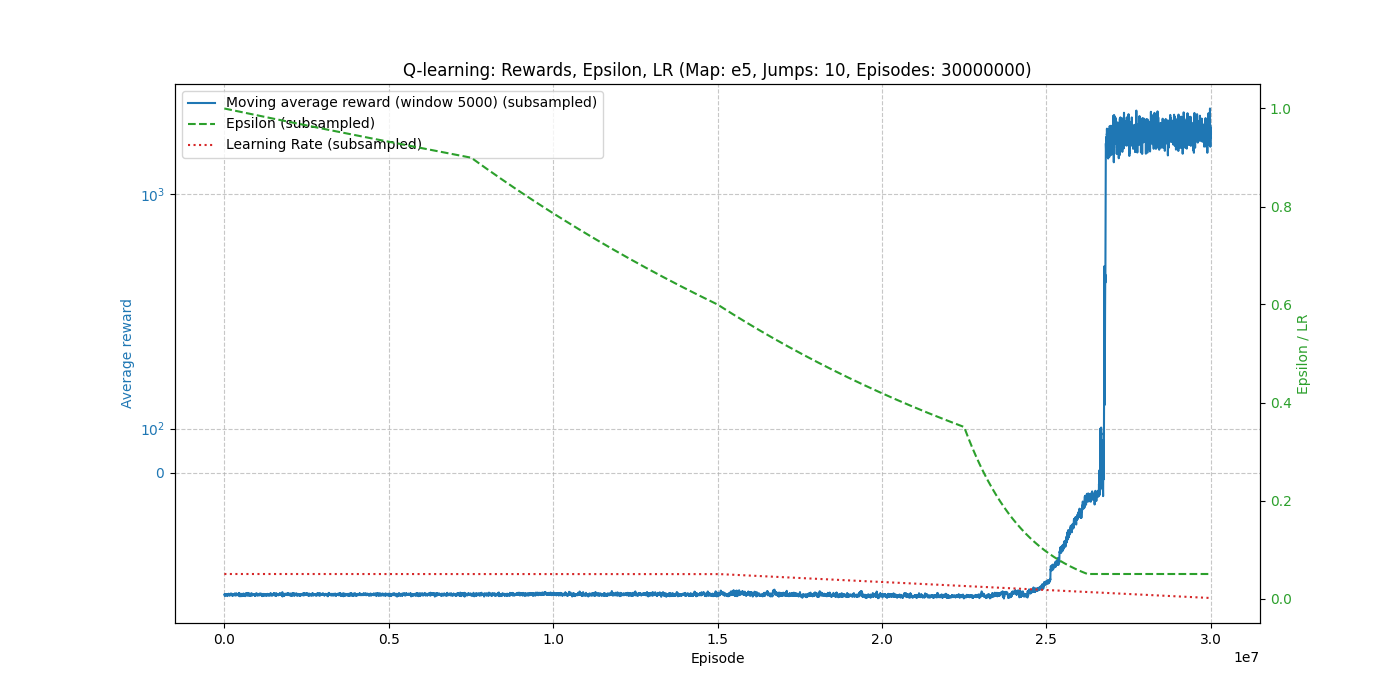

----------------------------------------------------------------------------------------------------
Wyświetlanie obrazka demonstracyjnego dla etapu map_name='e5', max_jumps=10:


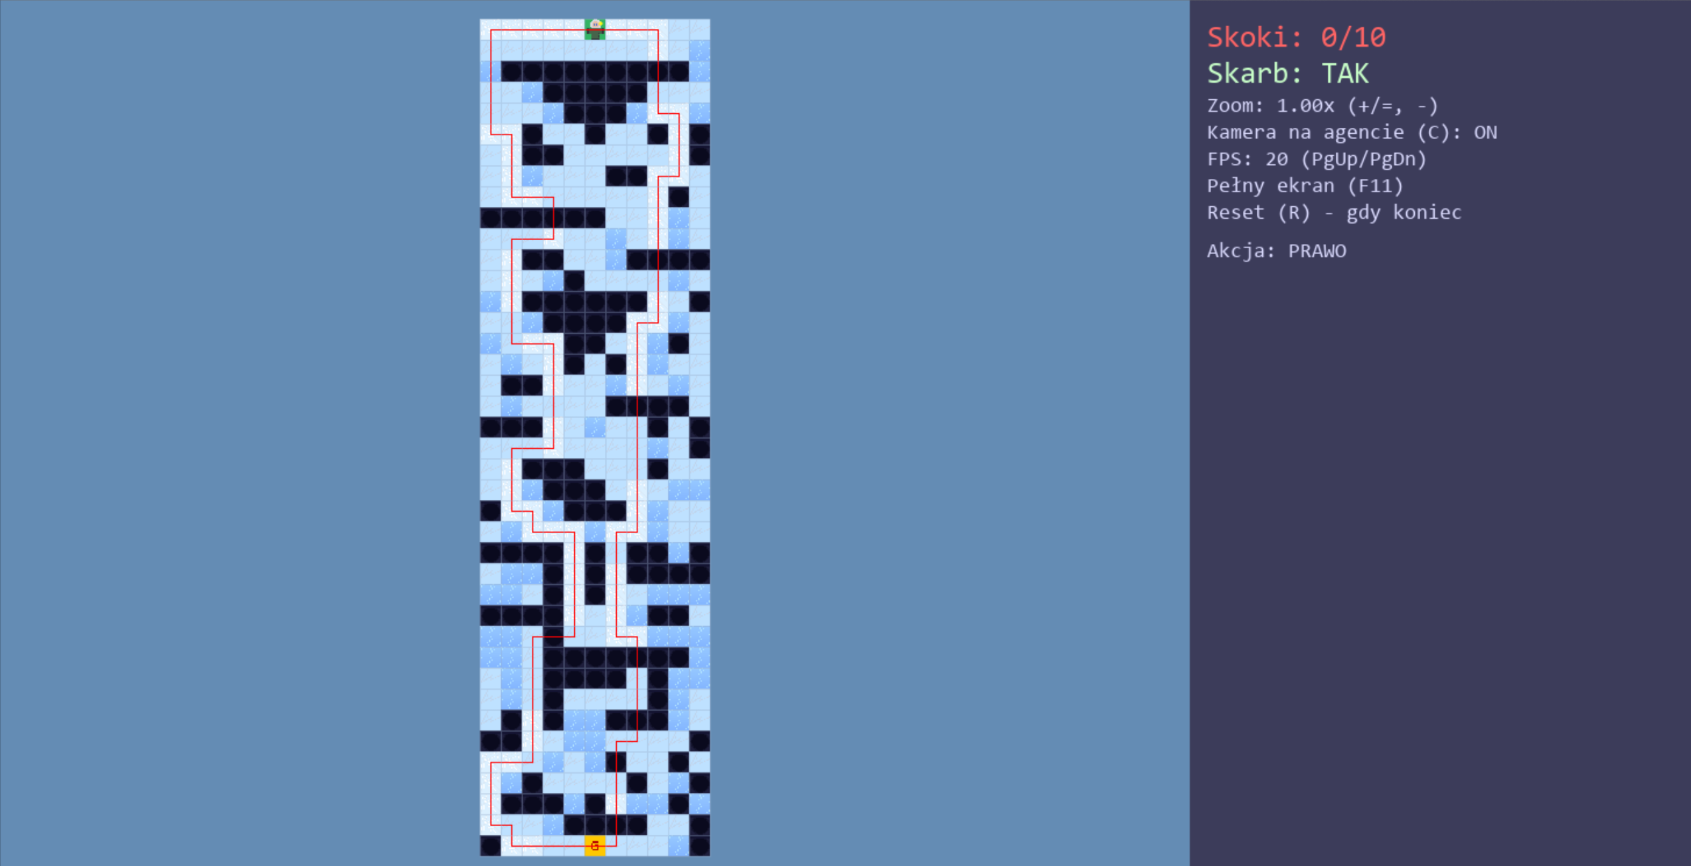

In [7]:
current_jumps_val_for_plot_and_demo = 10

plot_file_path = os.path.join(CURRICULUM_RUN_BASE_DIR,
                              f"map_{MAP_TO_USE.replace('x', '_')}_mj{current_jumps_val_for_plot_and_demo}",
                              f"rewards_epsilon_lr_mj{current_jumps_val_for_plot_and_demo}.png")

if os.path.exists(plot_file_path):
    print(f"Wyświetlanie wykresu treningowego dla etapu max_jumps = {current_jumps_val_for_plot_and_demo}:")
    display(IPImage(filename=plot_file_path))
else:
    print(f"Plik wykresu treningowego nie znaleziony: {plot_file_path}")

print("-" * 100)

assets_dir = ".\demonstration"
map_name_for_demo_path = MAP_TO_USE
demonstration_image_filename = f"demonstration_{map_name_for_demo_path}_mj{current_jumps_val_for_plot_and_demo}.png"
demonstration_image_path = os.path.join(assets_dir, demonstration_image_filename)

if os.path.exists(demonstration_image_path):
    print(
        f"Wyświetlanie obrazka demonstracyjnego dla etapu map_name='{map_name_for_demo_path}', max_jumps={current_jumps_val_for_plot_and_demo}:")
    display(IPImage(filename=demonstration_image_path))
else:
    print(f"Plik obrazka demonstracyjnego NIE ZNALEZIONY: {demonstration_image_path}")

### 5.4. Ocena Działania Agenta i Analiza Wyników

#### Analiza wykresu dla 10 skoków
Początkowa faza eksploracji (ok. 0 - 25m):** Przez znaczną większość epizodów średnia nagroda utrzymuje się na bardzo niskim, często ujemnym poziomie. Jest to typowe dla złożonych problemów z rzadkimi pozytywnymi nagrodami. Agent, mimo stopniowo malejącej wartości $\epsilon$ intensywnie eksploruje przestrzeń stanów i akcji. Koszty ruchu i skoków, a także kary za wpadnięcie w dziury lub nieprawidłowe ruchy, dominują nad rzadkimi sukcesami w dotarciu do celu. Wartość $\epsilon$ systematycznie spada zgodnie z zaimplementowanym harmonogramem wielofazowym, wymuszając na agencie coraz częstsze wykorzystywanie dotychczasowej, jeszcze słabej, wiedzy. Współczynnik uczenia początkowo jest stały, a następnie (od około 15m epizodu) zaczyna maleć, co może wpływać na tempo adaptacji wartości Q w późniejszych fazach.

Faza przełomu (ok. 25m - 27m epizodów):** Około 25 miliona epizodów następuje gwałtowny, niemal pionowy wzrost średniej nagrody. Jest to moment, w którym agent "odkrywa" lub zaczyna konsekwentnie stosować strategię prowadzącą do celu (zdobycie skarbu i powrót na start). Dopiero gdy $\epsilon$ zbliża się do końcowej wartości 0.05 model zaczyna wygrywać, co najprowdopodobniej wynika z tego że każdy losowy ruch może oznaczać wskoczenie do jeziora - koniec.

Faza eksploatacji i stabilizacji (ok. 27m - 30m epizodów):** Po przełomie średnia nagroda stabilizuje się na wysokim poziomie. Skala na osi Y pokazuje, że wartości te są znacznie wyższe niż początkowe (wartości $0-100$ mogą oznaczać regularne zbieranie skarbu, a skoki w okolice $10 000$ wskazują na osiąganie głównej nagrody za ukończenie gry).

#### Adaptacja Strategii i Oszczędzanie Zasobów
Przy większej liczbie dostępnych skoków (np. 10, jak na analizowanym wykresie): Agent może pozwalać sobie na częstsze używanie skoków, do szybszego pokonywania dłuższych, bezpiecznych odcinków, eksplorowania bardziej ryzykownych skrótów.

Przy mniejszej liczbie dostępnych skoków (np. 2, 3 lub 4) agent staje się znacznie bardziej zachowawczy i strategiczny w zarządzaniu tym ograniczonym zasobem. Wyraźnie widać, że im mniej skoków posiada, tym bardziej je oszczędza, rezerwując je na absolutnie kluczowe momenty lub segmenty trasy. Typowe zaobserwowane zachowania to:

* **Oszczędzanie skoków na drogę powrotną ze skarbem:** Gdy agent już posiada skarb, dotarcie na pole 'S' staje się priorytetem. Jeśli ma mało skoków, zachowa je, aby móc ominąć niebezpieczny obszar w drodze powrotnej lub znacząco skrócić ostatni, krytyczny etap podróży, minimalizując ryzyko porażki tuż przed osiągnięciem celu.
* **Używanie skoków do pokonania nieuniknionych, trudnych przeszkód lub aby znacząco skrócić trasę:** Jeśli na mapie istnieje fragment, który jest bardzo trudny lub czasochłonny do pokonania standardowymi ruchami (np. duży obszar kruchego lodu, konieczność ominięcia długiego rzędu dziur), a skok pozwala na jego efektywne pokonanie, agent nauczy się wykorzystać ten skok właśnie tam.

Ta umiejętność adaptacji i strategicznego gospodarowania ograniczonym zasobem (skokami) jest silnym wskaźnikiem, że agent nauczył się złożonej, celowej polityki, a jego działania nie są losowe. Agent podejmuje decyzje, które maksymalizują jego szansę na sukces w kontekście aktualnych ograniczeń.